In [1]:
import numpy as np
import pandas as pd
import random
import time
import math
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from dateutil import parser
from pathlib import Path
import json 
import shutil
import logging
logger = logging.getLogger(str(os.getpid()))

from wattile.data_reading import read_dataset_from_file
from wattile.buildings_processing import correct_predictor_columns, correct_timestamps, resample_or_rolling_stats, input_data_split
from wattile.time_processing import add_processed_time_columns
PROJECT_DIRECTORY = Path().resolve().parent.parent

In [2]:
#########################################################################################
# building the S2S model
class S2S_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(self.hidden_size, 1)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters. Refer to Saxe at al. paper that explains why to use orthogonal init weights
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # encoder forward function
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            h = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h

    def predict(self, pred_usage, h, target_length):
        # decoder forward function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h[0])
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#########################################################################################
# Bahdanau Attention model
# refer to : AuCson github code
# building the model
class S2S_BA_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_BA_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_cuda = use_cuda
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1+self.hidden_size, self.hidden_size)

        self.Wattn_energies = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.Wusage = nn.Linear(self.hidden_size, 1)
        self.Wout = nn.Linear(1+self.hidden_size*2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(self.hidden_size))
        stdv = 1./math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        self.init()

# function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.Wusage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.Wusage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h_copies = h.expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h, context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h_copies = h[0].expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h[0], context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#############################################################################################3
# Luong Attention module
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, " is not an appropriate attention method, please select one of dot, general, or concat.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        if self.method == 'concat':
            self.attn = nn.Linear(2*self.hidden_size, self.hidden_size)
            self.v = nn.Parameter(torch.rand(self.hidden_size))
            stdv = 1./math.sqrt(self.v.size(0))
            self.v.data.normal_(mean=0, std=stdv)

    def dot_score(self, hidden, encoder_output):
        attn_energies = torch.sum(hidden*encoder_output, dim=2)
        return attn_energies

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        attn_energies = torch.sum(hidden*energy, dim=2)
        return attn_energies

    def concat_score(self, hidden, encoder_output):
        energy = torch.tanh(self.attn(torch.cat((hidden.expand(encoder_output.shape[0], -1, -1),
                            encoder_output), 2)))
        return torch.sum(self.v * energy, dim=2)

    # calculate the attention weights (energies) based on the given method
    def forward(self, hidden, encoder_outputs):
        if self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)
        elif self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        attn_weights = torch.softmax(attn_energies, dim=1).unsqueeze(1)
        return attn_weights

#########################################################################################
#  building the S2S LA model
class S2S_LA_Model(nn.Module):
    def __init__(self, cell_type, attn_method, input_size, hidden_size, use_cuda):
        super(S2S_LA_Model, self).__init__()
        self.cell_type = cell_type
        self.attn_method = attn_method
        self.input_size = input_size
        self.hidden_size = hidden_size

        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(hidden_size, 1)
        self.lin_concat = nn.Linear(hidden_size*2, hidden_size)
        self.attn = Attn(self.attn_method, self.hidden_size)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.lin_usage(h)
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h, encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h, context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h[0], encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h[0], context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds
    
# loss function, qs here is an integer, not a list of integer
def quantile_loss(output, target, qs, window_target_size):
    """
    Computes loss for quantile methods.
    :param output: (Tensor)
    :param target: (Tensor)
    :param qs: (int)
    :param window_target_size: (int)
    :return: (Tensor) Loss for this study (single number)
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    resid = target - output
    tau = torch.tensor([qs], device=device).repeat_interleave(window_target_size)

    alpha = 0.001
    log_term = torch.zeros_like(resid, device=device)
    log_term[resid < 0] = torch.log(1 + torch.exp(resid[resid < 0] / alpha)) - (
        resid[resid < 0] / alpha
    )
    log_term[resid >= 0] = torch.log(1 + torch.exp(-resid[resid >= 0] / alpha))
    loss = resid * tau + alpha * log_term
    loss = torch.mean(torch.mean(loss, 0))

    return loss

### reading configs

In [3]:
"""
For this example, we will be using the default configs.
Check out the docs for an explaination of each config.
"""
##################################################################################
# choose the configs file to use as an input
##################################################################################
# main configs file
with open(PROJECT_DIRECTORY / "wattile" / "configs" / "configs.json", "r") as f:
    configs = json.load(f)
##################################################################################
# code testing configs file
# with open(PROJECT_DIRECTORY / "tests" / "fixtures" / "test_configs.json", "r") as f:
#     configs = json.load(f)
##################################################################################

exp_dir = PROJECT_DIRECTORY / "notebooks" / "exp_dir"
if exp_dir.exists():
    shutil.rmtree(exp_dir)
exp_dir.mkdir()

configs["data_output"]["exp_dir"] = str(PROJECT_DIRECTORY / exp_dir)
configs["data_input"]["data_dir"] = str(PROJECT_DIRECTORY / "data" / "Synthetic Site")

configs

{'data_input': {'data_dir': 'C:\\Users\\JKIM4\\Documents\\GitHub\\intelligentcampus-pred-analytics\\data\\Synthetic Site',
  'data_config': 'Synthetic Site Config.json',
  'start_time': '2018-01-01T00:00:00-07:00',
  'end_time': '2022-01-01T00:00:00-07:00',
  'predictor_columns': ['Synthetic Weather Station Dew Point Temperature',
   'Synthetic Weather Station Diffuse Horizontal Irradiance',
   'Synthetic Weather Station Direct Normal Irradiance',
   'Synthetic Weather Station Dry Bulb Temperature',
   'Synthetic Weather Station Global Horizontal Irradiance',
   'Synthetic Weather Station Relative Humidity',
   'Synthetic Weather Station Wind Speed'],
  'target_var': 'Synthetic Site Electricity Main Total Power'},
 'data_output': {'exp_dir': 'C:\\Users\\JKIM4\\Documents\\GitHub\\intelligentcampus-pred-analytics\\notebooks\\exp_dir',
  'plot_comparison': True,
  'plot_comparison_portion_start': 0.0,
  'plot_comparison_portion_end': 1.0},
 'data_processing': {'feat_time': {'month_of_year

### reading data

In [4]:
data = read_dataset_from_file(configs)
data

,Synthetic Weather Station Dew Point Temperature,Synthetic Weather Station Diffuse Horizontal Irradiance,Synthetic Weather Station Direct Normal Irradiance,Synthetic Weather Station Dry Bulb Temperature,Synthetic Weather Station Global Horizontal Irradiance,Synthetic Weather Station Relative Humidity,Synthetic Weather Station Wind Speed,Synthetic Site Electricity Main Total Power
Timestamp,,,,,,,,
2021-12-01 07:00:00+00:00,15.413733,-1.525850,-0.005199,56.408001,-1.810825,17.930000,10.457981,104.800003
2021-12-01 07:01:00+00:00,15.183906,-1.496226,0.207964,56.174000,-1.841866,17.879999,11.265539,96.650002
2021-12-01 07:02:00+00:00,14.891221,-1.441191,0.457520,55.886002,-1.873579,17.809999,12.777752,96.199997
2021-12-01 07:03:00+00:00,14.836164,-1.371754,0.473117,55.796001,-1.860084,17.820000,12.694983,95.599998
2021-12-01 07:04:00+00:00,14.782966,-1.317349,0.545903,55.723999,-1.843271,17.820000,11.632407,100.650002
...,...,...,...,...,...,...,...,...
2021-12-08 06:55:00+00:00,11.210565,-1.487212,-0.254757,42.285198,-1.814939,24.680000,0.000000,109.664803
2021-12-08 06:56:00+00:00,11.190062,-1.445182,-0.233960,41.997200,-1.852901,24.930000,0.000000,107.002800
2021-12-08 06:57:00+00:00,11.223961,-1.396302,-0.145575,41.669601,-1.841248,25.290001,3.545647,106.480400


### feature extraction

In [5]:
# assert we have the correct columns and order them
data = correct_predictor_columns(configs, data)

# sort and trim data specified time period
data = correct_timestamps(configs, data)

# Add time-based features
data = add_processed_time_columns(data, configs)

# Add statistics features
data = resample_or_rolling_stats(data, configs)

data

,Synthetic Weather Station Dew Point Temperature_min,Synthetic Weather Station Diffuse Horizontal Irradiance_min,Synthetic Weather Station Direct Normal Irradiance_min,Synthetic Weather Station Dry Bulb Temperature_min,Synthetic Weather Station Global Horizontal Irradiance_min,Synthetic Weather Station Relative Humidity_min,Synthetic Weather Station Wind Speed_min,sin_HOD_min,cos_HOD_min,HOD_binary_reg_0_min,...,DOW_binary_fuzzy_0_mean,DOW_binary_fuzzy_1_mean,DOW_binary_fuzzy_2_mean,DOW_binary_fuzzy_3_mean,DOW_binary_fuzzy_4_mean,DOW_binary_fuzzy_5_mean,DOW_binary_fuzzy_6_mean,sin_MOY_mean,cos_MOY_mean,Synthetic Site Electricity Main Total Power
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-01 07:00:00+00:00,15.413733,-1.525850,-0.005199,56.408001,-1.810825,17.930000,10.457981,0.965926,-2.588190e-01,0.0,...,0.0,0.0,0.708333,0.291667,0.0,0.0,0.0,-0.493776,0.869589,104.800003
2021-12-01 07:15:00+00:00,14.782966,-1.496226,-0.540707,55.112000,-1.873579,17.809999,9.395406,0.946930,-3.214395e-01,0.0,...,0.0,0.0,0.708333,0.291667,0.0,0.0,0.0,-0.493776,0.869589,103.650002
2021-12-01 07:30:00+00:00,15.474850,-1.379412,-1.741706,54.608002,-1.918852,18.690001,8.612455,0.923880,-3.826834e-01,0.0,...,0.0,0.0,0.708333,0.291667,0.0,0.0,0.0,-0.493776,0.869589,98.050003
2021-12-01 07:45:00+00:00,16.614972,-1.642929,-2.147240,53.743999,-2.029242,19.320000,4.503084,0.896873,-4.422887e-01,0.0,...,0.0,0.0,0.708333,0.291667,0.0,0.0,0.0,-0.493776,0.869589,98.349998
2021-12-01 08:00:00+00:00,16.413343,-1.480409,-0.426325,52.807999,-1.958610,21.090000,3.746977,0.866025,-5.000000e-01,0.0,...,0.0,0.0,0.705556,0.294444,0.0,0.0,0.0,-0.493776,0.869589,102.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 06:00:00+00:00,11.961447,-1.673728,-1.211398,41.388802,-1.909901,25.160000,0.000000,0.998135,-1.608123e-16,0.0,...,0.0,0.0,0.788889,0.211111,0.0,0.0,0.0,-0.385663,0.922640,104.668396
2021-12-08 06:15:00+00:00,11.008480,-1.489343,-0.504314,41.646198,-1.936419,24.240000,0.000000,0.997859,-6.540313e-02,0.0,...,0.0,0.0,0.750000,0.250000,0.0,0.0,0.0,-0.385663,0.922640,102.709602
2021-12-08 06:30:00+00:00,10.851442,-1.571301,-0.655083,42.024200,-1.834018,23.760000,0.000000,0.991445,-1.305262e-01,0.0,...,0.0,0.0,0.750000,0.250000,0.0,0.0,0.0,-0.385663,0.922640,105.972198


In [6]:
# data.to_csv("./output.csv")

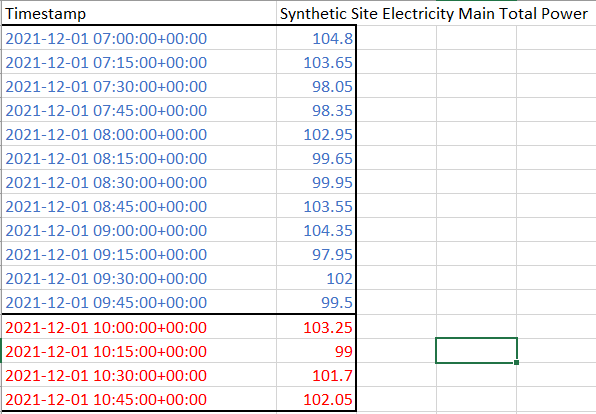

# =======================================
# modified workflow
# =======================================

In [7]:
def _create_split_mask(timestamp, data_size, configs):

    # set configuration parameters
    np.random.seed(seed=configs["data_processing"]["random_seed"])
    active_sequential = configs["data_processing"]["sequential_splicer"]["active"]
    train_ratio = int(configs["data_processing"]["data_split"].split(":")[0]) / 100
    val_ratio = int(configs["data_processing"]["data_split"].split(":")[1]) / 100
    test_ratio = int(configs["data_processing"]["data_split"].split(":")[2]) / 100
    window_witdh = configs["data_processing"]["sequential_splicer"]["window_width"]
    train_size_factor = configs["data_processing"]["train_size_factor"]

    # split data based on random sequential chunks
    if active_sequential:
        # set indices for training set
        splicer = ((timestamp - timestamp[0]) // pd.Timedelta(window_witdh)).values
        num_chunks = splicer[-1]
        num_train_chunks = (train_ratio * num_chunks) - (
            (train_ratio * num_chunks) % train_size_factor
        )
        if num_train_chunks == 0:
            raise Exception(
                "Total number of data chunks is zero. train_size_factor value might be too "
                "large compared to the data size. Exiting.."
            )
        msk = np.zeros(timestamp.shape[0]) + 2
        train_chunks = np.random.choice(
            np.arange(num_chunks), replace=False, size=int(num_train_chunks)
        )
        for chunk in train_chunks:
            indices = np.where(splicer == chunk)
            msk[indices] = 0

        # set indices for validation and test set
        remaining_chunks = np.setdiff1d(np.arange(num_chunks), train_chunks)
        if test_ratio == 0:
            msk[msk != 0] = 1
        else:
            num_val_chunks = int(
                (val_ratio / (1 - train_ratio)) * remaining_chunks.shape[0]
            )
            val_chunks = np.random.choice(
                remaining_chunks, replace=False, size=num_val_chunks
            )
            for chunk in val_chunks:
                indices = np.where(splicer == chunk)
                msk[indices] = 1

    # split data based on random timestamp sampling
    else:
        # set indices for training set
        num_ones = (train_ratio * data_size) - (
            (train_ratio * data_size) % train_size_factor
        )
        msk = np.zeros(data_size) + 2
        indices = np.random.choice(
            np.arange(data_size), replace=False, size=int(num_ones)
        )
        msk[indices] = 0

        # set indices for validation and test set
        remaining_indices = np.where(msk != 0)[0]
        if test_ratio == 0:
            msk[remaining_indices] = 1
        else:
            num_val = int((val_ratio / (1 - train_ratio)) * remaining_indices.shape[0])
            val_indices = np.random.choice(
                remaining_indices, replace=False, size=num_val
            )
            msk[val_indices] = 1

    return msk

In [8]:
def input_data_split(data, configs):
    """
    Split a data set into a training set and a validation (val) set.
    Methods: "Random" or "Sequential", specified in configs

    :param data: (DataFrame)
    :param configs: (Dict)
    :return:
    """
    # setting configuration parameters
    arch_version = configs["learning_algorithm"]["arch_version"]
    file_prefix = Path(configs["data_output"]["exp_dir"])
    mask_file = os.path.join(file_prefix, "mask.h5")

    # assign timestamp and data size depending on arch_version
    if (arch_version == "alfa") | (arch_version == "bravo"):
        timestamp = data.index
        data_size = data.shape[0]

    elif arch_version == "charlie":
        timestamp = data["timestamp"]
        data_size = data["predictor"].shape[0]

    msk = _create_split_mask(timestamp, data_size, configs)

    # assign train, validation, and test data
    if (arch_version == "alfa") | (arch_version == "bravo"):
        train_df = data[msk == 0]
        val_df = data[msk == 1]
        test_df = data[msk == 2]
        # Get rid of datetime index
        train_df.reset_index(drop=True, inplace=True)
        val_df.reset_index(drop=True, inplace=True)
        # save test_df to file for later use
        test_df.to_hdf(
            os.path.join(file_prefix, "internal_test.h5"), key="df", mode="w"
        )

    elif arch_version == "charlie":
        train_df = {}
        val_df = {}
        train_df_predictor = data["predictor"][msk == 0, :, :]
        train_df_target = data["target"][msk == 0, :, :]
        val_df_predictor = data["predictor"][msk == 1, :, :]
        val_df_target = data["target"][msk == 1, :, :]
        test_df_predictor = data["predictor"][msk == 2, :, :]
        test_df_target = data["target"][msk == 2, :, :]
        train_df["predictor"] = train_df_predictor
        train_df["target"] = train_df_target
        val_df["predictor"] = val_df_predictor
        val_df["target"] = val_df_target
        # save test_df to file for later use
        np.save(
            os.path.join(file_prefix, "internal_test_predictor.npy"), test_df_predictor
        )
        np.save(os.path.join(file_prefix, "internal_test_target.npy"), test_df_target)

    # save mask file to preserve timeseries index
    mask = pd.DataFrame()
    mask["msk"] = msk
    mask["index"] = timestamp
    mask = mask.set_index("index")
    mask.to_hdf(mask_file, key="df", mode="w")

    return train_df, val_df

### roll_predictors_target

In [9]:
# setting configuration settings
file_prefix = Path(configs["data_output"]["exp_dir"])
configs["learning_algorithm"]["arch_version"] = "charlie"
configs["data_processing"]["sequential_splicer"]["active"] = False
configs["learning_algorithm"]["num_epochs"] = 100

# reading configuration settings
configs["data_processing"]["input_output_window"] = {
    "window_width_source": "180min",
    "window_width_futurecast":"0min",
    "window_width_target": "45min",
 }

In [12]:
# def roll_predictors_target(data, configs):
    
"""
Create rolling windows of predictor and target variables in a DataFrame.
Used specifically for charlie learning methods.

:param data: (DataFrame)
:param configs: (Dict)
:return: (Dict)
"""

# setting configuration parameters
window_width_source = configs["data_processing"]["input_output_window"][
    "window_width_source"
]
window_width_futurecast = configs["data_processing"]["input_output_window"][
    "window_width_futurecast"
]
window_width_target = configs["data_processing"]["input_output_window"][
    "window_width_target"
]
bin_interval = configs["data_processing"]["resample"]["bin_interval"]
target_var = configs["data_input"]["target_var"]
target = data[target_var].copy()

#################################################################################
# ToDos
# do we don't shift here so that predictors can retain original timestamps of target
#################################################################################
# shift target for futurecast
data[target_var] = target.shift(freq="-" + window_width_futurecast)

# initialize lists
data_predictor = []
data_target = []

# calculate number of rows based on window size defined by time
#################################################################################
# ToDos
# add count one?
#################################################################################
window_source_size_count = pd.Timedelta(window_width_source)//pd.Timedelta(bin_interval) + 1
window_target_size_count = pd.Timedelta(window_width_target)//pd.Timedelta(bin_interval) + 1

#################################################################################
# ToDos
# cutoff/shift some timestamps based on input_output_window parameters?
#################################################################################
# set aside timeindex
timestamp = data.iloc[
    : -(window_source_size_count + window_target_size_count - 1), :
].index

In [13]:
#################################################################################
# ToDos
# do we take out target or retain target?
#################################################################################
# create 3D predictor data
data_shifted_predictor = data.iloc[:-window_target_size_count, :]
for window in data_shifted_predictor.rolling(window=window_width_source, closed="both"):
    if window.shape[0] == window_source_size_count:
        data_predictor.append(
            window.values.reshape(
                (1, window_source_size_count, data_shifted_predictor.shape[1])
            )
        )
# reshape data dimension
data_predictor = np.concatenate(np.array(data_predictor), axis=0)

In [16]:
data_predictor.shape

(657, 13, 220)

In [21]:
pd.DataFrame(data_predictor[-1,:,:])

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,14.678328,-1.478887,-0.618691,45.528801,-1.846220,25.400000,2.628477,0.662620,7.071068e-01,0.0,...,0.0,0.0,0.913889,0.086111,0.0,0.0,0.0,-0.385663,0.92264,108.449402
1,15.459722,-1.662790,-0.545906,45.321800,-1.972469,26.379999,0.000000,0.710185,6.593458e-01,0.0,...,0.0,0.0,0.875000,0.125000,0.0,0.0,0.0,-0.385663,0.92264,99.728195
2,15.816122,-1.673001,-1.232188,45.206600,-1.932019,27.139999,0.000000,0.754710,6.087614e-01,0.0,...,0.0,0.0,0.875000,0.125000,0.0,0.0,0.0,-0.385663,0.92264,104.696602
3,14.491569,-1.758082,-0.883846,44.814201,-1.894902,24.480000,0.000000,0.796002,5.555702e-01,0.0,...,0.0,0.0,0.875000,0.125000,0.0,0.0,0.0,-0.385663,0.92264,105.990005
4,14.272826,-1.810917,-0.410726,44.230999,-2.073794,24.350000,0.000000,0.833886,5.000000e-01,0.0,...,0.0,0.0,0.872222,0.127778,0.0,0.0,0.0,-0.385663,0.92264,102.918999
5,13.537465,-1.290286,0.036394,42.015202,-2.026497,27.660000,3.049033,0.868199,4.422887e-01,0.0,...,0.0,0.0,0.833333,0.166667,0.0,0.0,0.0,-0.385663,0.92264,108.709801
6,13.050873,-1.292175,-0.379534,42.103401,-1.832218,26.920000,3.283918,0.898794,3.826834e-01,0.0,...,0.0,0.0,0.833333,0.166667,0.0,0.0,0.0,-0.385663,0.92264,103.291397
7,12.989726,-1.507122,-0.920239,42.233002,-1.802816,26.350000,0.000000,0.925541,3.214395e-01,0.0,...,0.0,0.0,0.833333,0.166667,0.0,0.0,0.0,-0.385663,0.92264,103.205399
8,13.007077,-1.483804,-0.691482,41.601200,-1.910717,26.430000,0.000000,0.948324,2.588190e-01,0.0,...,0.0,0.0,0.830556,0.169444,0.0,0.0,0.0,-0.385663,0.92264,105.448799
9,13.007276,-1.448462,-0.660286,40.674198,-1.834482,27.639999,0.000000,0.967046,1.950903e-01,0.0,...,0.0,0.0,0.791667,0.208333,0.0,0.0,0.0,-0.385663,0.92264,107.037003


In [17]:
#################################################################################
# ToDos
# reflect futurecast to the algorithm
# check if target entry size is the same as window_width_target
#################################################################################
# create 3D target data
data_shifted_target = data.loc[
    data.index >= data.shift(freq=window_width_source).index[0], :
][target_var]
for window in data_shifted_target.rolling(window=window_width_target, closed="both"):
    if window.shape[0] == window_target_size_count:
        data_target.append(window.values.reshape((1, window_target_size_count, 1)))
# reshape data dimension
data_target = np.concatenate(np.array(data_target), axis=0)

In [18]:
data_target.shape

(658, 4, 1)

In [22]:
pd.DataFrame(data_target[-1,:,:])

,0
0,102.709602
1,105.972198
2,112.989998
3,104.239998


In [ ]:
# combine 3D predictor and target data into dictionary
data = {}
data["predictor"] = data_predictor
data["target"] = data_target
data["timestamp"] = timestamp

# return data

In [ ]:
data["predictor"].shape

In [ ]:
i=0
print("##############################################")
print(pd.DataFrame(data["predictor"][i,:,:]))
print("##############################################")
print(pd.DataFrame(data["target"][i,:,:]))

In [ ]:
###################################################
# roll_full_data_s2s
###################################################
data = roll_predictors_target(data, configs)

In [ ]:
###################################################
# input_data_split
###################################################
train_df, val_df = input_data_split(data, configs)

In [ ]:
def encoder_decoder_loss(
    model, 
    attention_model, 
    loss_fn, 
    x, 
    y_usage, 
    loss_function_qs, 
    window_target_size_count):
    
    # encoder forward, for respective models
    if attention_model == "none":
        pred_usage, h = model.consume(x)

    elif attention_model == "BA":
        pred_usage, h, encoder_outputs = model.consume(x)

    elif attention_model == "LA":
        pred_usage, h, encoder_outputs = model.consume(x)

    # decoder forward, for respective models
    if attention_model == "none":
        preds = model.predict(pred_usage, h, window_target_size_count)

    elif attention_model == "BA":
        preds = model.predict(
            pred_usage, h, encoder_outputs, window_target_size_count
        )

    elif attention_model == "LA":
        preds = model.predict(
            pred_usage, h, encoder_outputs, window_target_size_count
        )

    # compute lose
    loss_usage = loss_fn(
        preds,
        y_usage,
        qs=loss_function_qs,
        window_target_size=window_target_size_count,
    )
    
    return preds, loss_usage

In [ ]:
def training_validating(
    train_df_predictor,
    train_df_target,
    val_df_predictor,
    val_df_target,
    model,
    loss_fn,
    attention_model,
    window_target_size_count,
    epochs,
    loss_function_qs,
    batch_size,
    opt,
    cuda,
):

    train_loss = []
    test_loss = []

    i = 0

    for epoch in range(epochs):
        ###################################################
        # TRAINING
        ###################################################
        print(
            "{} ###############################################################".format(
                i
            )
        )
        t_one_epoch = time.time()
        print("Epoch {}".format(epoch + 1))
        total_usage_loss = 0
        for b_idx in range(0, train_df_predictor.shape[0], batch_size):

            x = torch.from_numpy(train_df_predictor[b_idx : b_idx + batch_size]).float()
            y_usage = torch.from_numpy(
                train_df_target[b_idx : b_idx + batch_size]
            ).float()

            if cuda:
                x = x.cuda()
                y_usage = y_usage.cuda()

            # encoder, decoder, loss
            preds, loss_usage = encoder_decoder_loss(
                model, 
                attention_model, 
                loss_fn, 
                x, 
                y_usage, 
                loss_function_qs, 
                window_target_size_count
            )

            # backprop and update
            opt.zero_grad()

            loss_usage.sum().backward()

            opt.step()

            total_usage_loss += loss_usage.item()

        train_loss.append(total_usage_loss)
        print("\tTRAINING: {} total train USAGE loss.\n".format(total_usage_loss))

        ###################################################
        # TESTING
        ###################################################
        y_usage = None
        pred_usage = None
        preds = None
        total_usage_loss = 0
        all_preds = []

        for b_idx in range(0, val_df_predictor.shape[0], batch_size):
            with torch.no_grad():
                x = torch.from_numpy(val_df_predictor[b_idx : b_idx + batch_size])
                y_usage = torch.from_numpy(val_df_target[b_idx : b_idx + batch_size])

                if cuda:
                    x = x.cuda()
                    y_usage = y_usage.cuda()

                # encoder, decoder, loss
                preds, loss_usage = encoder_decoder_loss(
                    model, 
                    attention_model, 
                    loss_fn, 
                    x, 
                    y_usage, 
                    loss_function_qs, 
                    window_target_size_count
                )

                if epoch == epochs - 1:
                    all_preds.append(preds)

                total_usage_loss += loss_usage.item()

        test_loss.append(total_usage_loss)

        print("\tTESTING: {} total test USAGE loss".format(total_usage_loss))
        print("\tTESTING:\n")
        print("\tSample of prediction:")
        print("\t\t TARGET: {}".format(y_usage[-1].cpu().detach().numpy().flatten()))
        print("\t\t   PRED: {}\n\n".format(preds[-1].cpu().detach().numpy().flatten()))

        y_last_usage = y_usage[-1].cpu().detach().numpy().flatten()
        pred_last_usage = preds[-1].cpu().detach().numpy().flatten()
        t2_one_epoch = time.time()
        time_one_epoch = t2_one_epoch - t_one_epoch
        print(
            "TIME OF ONE EPOCH: {} seconds and {} minutes".format(
                time_one_epoch, time_one_epoch / 60.0
            )
        )

        i += 1

    return model, all_preds, train_loss, test_loss, y_last_usage, pred_last_usage

In [ ]:
def main(train_df, val_df, configs, loss_function_qs):
    """
    TBD
    """
    t0 = time.time()
    cuda = configs["S2S_learning"]["cuda"]
    cell_type = configs["S2S_learning"]["cell_type"]
    attention_model = configs["S2S_learning"]["attention_model"]
    la_method = configs["S2S_learning"]["la_method"]
    batch_size = configs["S2S_learning"]["batch_size"]
    hidden_size = configs["S2S_learning"]["hidden_size"]
    save_model = configs["S2S_learning"]["save_model"]
    seed = configs["random_seed"]
    torch.manual_seed(configs["random_seed"])
    epochs = configs["num_epochs"]
    window_source_size = configs["S2S_window"]["window_width_source"]
    window_target_size = configs["S2S_window"]["window_width_target"]
    resample_interval = configs["resample_interval"]
    window_target_size_count = int(
        pd.Timedelta(window_target_size) / pd.Timedelta(resample_interval)
    )
    train_df_predictor = train_df["predictor"].astype(np.float32).copy()
    train_df_target = train_df["target"].astype(np.float32).copy()
    val_df_predictor = val_df["predictor"].astype(np.float32).copy()
    val_df_target = val_df["target"].astype(np.float32).copy()
    usage_actual = val_df_target.flatten()

    t0 = time.time()
    np.random.seed(seed)
    torch.manual_seed(seed)

    print(
        "Created {} train samples and {} test samples".format(
            train_df_predictor.shape[0], val_df_predictor.shape[0]
        )
    )

    ###################################################
    # call the model
    ###################################################
    input_dim = configs["input_dim"] = train_df_predictor.shape[-1]

    # call the respective model
    if attention_model == "none":
        model = S2S_Model(cell_type, input_dim, hidden_size, use_cuda=cuda)

    elif attention_model == "BA":
        model = S2S_BA_Model(cell_type, input_dim, hidden_size, use_cuda=cuda)

    elif attention_model == "LA":
        model = S2S_LA_Model(
            cell_type, la_method, input_dim, hidden_size, use_cuda=cuda
        )

    if cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        model.cuda()

    print("MODEL ARCHITECTURE IS: ")
    print(model)

    print("\nModel parameters are on cuda: {}".format(next(model.parameters()).is_cuda))

    opt = optim.Adam(model.parameters(), lr=1e-3)
    # loss_fn = nn.MSELoss(reduction='sum')
    loss_fn = quantile_loss

    # EPOCHES = epochs
    # BATCH_SIZE = batch_size

    print("\nStarting training...")

    ###################################################
    # TRAINING
    ###################################################
    model, all_preds, train_loss, test_loss, y_last_usage, pred_last_usage = training_validating(
        train_df_predictor,
        train_df_target,
        val_df_predictor,
        val_df_target,
        model,
        loss_fn,
        attention_model,
        window_target_size_count,
        epochs,
        loss_function_qs,
        batch_size,
        opt,
        cuda,
    )

    ###################################################
    # SAVING MODEL
    ###################################################
    if save_model:
        torch.save(
            model.state_dict(),
            # MODEL_w:__seed={}_cell_type={}_attention_model={}_la_method={}_T={}_N={}_bs={}_hs={}
            "MODEL_w:{}_{}_{}_{}_{}_{}_{}_{}".format(
                seed,
                cell_type,
                attention_model,
                la_method,
                window_source_size,
                window_target_size,
                batch_size,
                hidden_size,
            ),
        )

    ###################################################
    # saving results
    ###################################################
    # for plotting and accuracy
    predictions = pd.DataFrame(all_preds[0].numpy().squeeze())
    predictions = predictions.add_prefix("{}_".format(str(loss_function_qs)))
    targets = pd.DataFrame(val_df_target.squeeze())    
    
    predictions.to_hdf(
        os.path.join(file_prefix, "predictions.h5"), key="df", mode="w"
    )
    targets.to_hdf(
        os.path.join(file_prefix, "measured.h5"), key="df", mode="w"
    )
    #########################################################################

    # total time of run
    t1 = time.time()
    total = t1 - t0
    print("\nTIME ELAPSED: {} seconds OR {} minutes".format(total, total / 60.0))
    print("\nEnd of run")

In [ ]:
for loss_function_qs in [0.50]: #[0.50]:#[0.05, 0.50, 0.95]:
    print(f"Processing loss function alpha: {loss_function_qs}")
    if __name__ == "__main__":
        main(
            train_df = train_df,
            val_df = val_df,
            configs = configs,
            loss_function_qs = loss_function_qs
        )        

